In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
from sympy import *
x, y = symbols("x y")

### Example 2.4 (from Arora, 2012 [7] pp.759-760)

Let an RO problem be the following program:

$$
\begin{aligned}
\text{minimize } f(x,y) &= x^2 - \frac{1}{4} y^2 + x y \cos(x) - \exp(y) \\
\text{subject to } &\quad g_1(x,y) =-6 -x+(x-1)^2 + y^2 \leq 0 \\
&\quad g_2(x,y)=-5-\frac{1}{10}y+\frac{3}{7}x^2+(y-1)^2 \leq 0 \\
&\quad x,y \in [-2, 2]
\end{aligned}
$$

where the design variables have a Gaussian distribution of the type:

$$
u(x; \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)
$$
and similarly for $y$.

Suppose that the standard deviations are $\sigma_{x} = \sigma_{y} = 0.1$ and that the maximum tolerances are $\epsilon_x = \epsilon_y = 0.3$. The user-defined coefficients are $w_x = w_y = 0.5$ and $k_x = k_y = 0.5$.

In [ ]:
obj = x**2 - (y**2)/4 + x*y* cos(x)- exp(y)
constr1 = -6 -x +(x-1)**2 + y**2
constr2 = -5 - y/10 +(3/7)* x**2 +(y-1)**2
bnds = ((-2., 2.), (-2., 2.))

sigmas=[0.1,0.1]
tolerances=[epsx,epsy]=[0.3,0.3]

weights_obj=[0.5,0.5] ### weights in the objectives
weights_costr1=[1.,0.5]  ## weights in mean variance constr 1
weights_costr2=[1.,0.5]  ## weights in mean variance constr 1
 
initial_point=[0.4,0.4]

Compute gradients

In [78]:
grad_obj=[Derivative(obj, var).doit() for var in [x,y]]
grad_costr1=[Derivative(constr1, var).doit() for var in [x,y]]
grad_costr2=[Derivative(constr2, var).doit() for var in [x,y]]

Compute variance-related part of the objectives

In [79]:
sigma_obj=[(g*sx)**2 for g,sx in zip(grad_obj,sigmas)]
sigma_costr1=sum([abs(g*ex) for g,ex in zip(grad_costr1,tolerances)])
sigma_costr2=sum([abs(g*ex) for g,ex in zip(grad_costr2,tolerances)])

Check sanity of the initial guess

In [80]:
norm_n=[abs(f.evalf(subs={x: initial_point[0],
                      y: initial_point[1]})) for f in 
       [obj,sqrt(sum(sigma_obj))]
       ]


norm_n

[1.22445493860081, 0.172478526075789]

Arrange robust optimization objectives

In [81]:
minimize_obj = sum([o*w/n for o,w,n in zip([obj,sqrt(sum(sigma_obj))],weights_obj,norm_n)])
satisfy_constr1 = sum([c*k for c,k in zip([constr1,sigma_costr1],weights_costr1)])
satisfy_constr2 = sum([c*k for c,k in zip([constr2,sigma_costr2],weights_costr2)])

Turn symbolic objectives into python functions and mind that scipy minimize treats inequality constraints as $g(x)\geq0$ by default

In [82]:
f_minimize_obj = lambdify([(x, y)], minimize_obj)
f_satisfy_constr1 = lambdify([(x, y)], -satisfy_constr1)
f_satisfy_constr2 = lambdify([(x, y)], -satisfy_constr2)

In [83]:
from scipy.optimize import minimize


cons=[{'type':'ineq', 'fun': f_satisfy_constr1},
       {'type':'ineq', 'fun': f_satisfy_constr2}]

optimal_x = []
opt_eps=[]

res = minimize(f_minimize_obj, initial_point, method='SLSQP', bounds=bnds, constraints=cons)
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.7625623047877887
       x: [ 2.029e-01  1.982e+00]
     nit: 11
     jac: [ 7.268e-01 -1.049e+00]
    nfev: 34
    njev: 11

In [84]:
x_min=res.x

print(f_minimize_obj(x_min),f_satisfy_constr1(x_min),f_satisfy_constr2(x_min))


-0.7625623047877887 -5.163816041431346e-10 3.7070005783437576


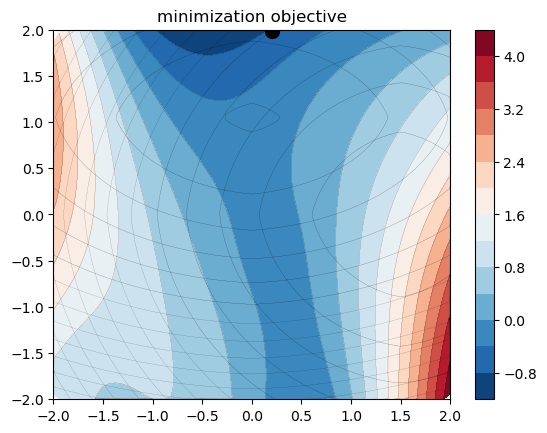

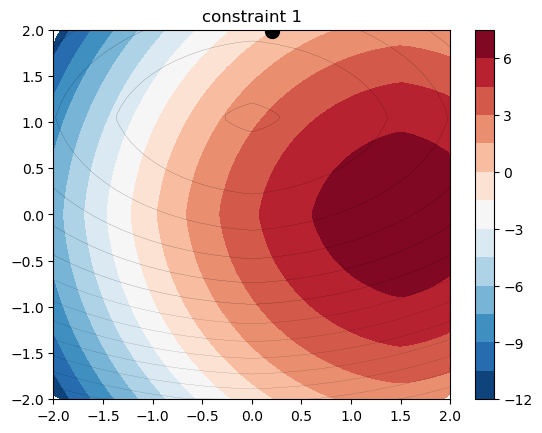

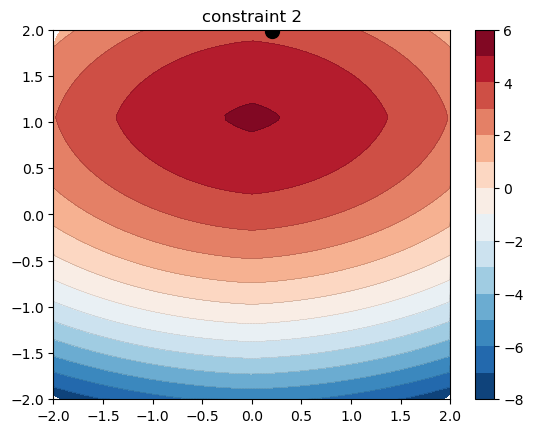

In [85]:
npts=10000
x_list=np.random.rand(npts)*4-2
y_list=np.random.rand(npts)*4-2
f_obj_list=[f_minimize_obj([xi,yi]) for xi,yi in zip(x_list,y_list)]
g1_constr_list=[f_satisfy_constr1([xi,yi]) for xi,yi in zip(x_list,y_list)]
g2_constr_list=[f_satisfy_constr2([xi,yi]) for xi,yi in zip(x_list,y_list)]



fig, ax2 = plt.subplots(nrows=1)

ax2.tricontour(x_list, y_list, f_obj_list, levels=14, linewidths=0.1, colors='k')
cntr2 = ax2.tricontourf(x_list, y_list, f_obj_list, levels=14, cmap="RdBu_r")
ax2.tricontour(x_list, y_list, g1_constr_list, levels=14, linewidths=0.1, colors='k')
ax2.tricontour(x_list, y_list, g2_constr_list, levels=14, linewidths=0.1, colors='k')

fig.colorbar(cntr2, ax=ax2)
ax2.plot(x_min[0], x_min[1], 'ko', ms=10)
ax2.set(xlim=(-2, 2), ylim=(-2, 2))
ax2.set_title('minimization objective' )

plt.subplots_adjust(hspace=0.5)
plt.show()




fig, ax2 = plt.subplots(nrows=1)

ax2.tricontour(x_list, y_list, g2_constr_list, levels=14, linewidths=0.1, colors='k')
cntr2 = ax2.tricontourf(x_list, y_list, g1_constr_list, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(x_min[0], x_min[1], 'ko',  ms=10)
ax2.set(xlim=(-2, 2), ylim=(-2, 2))
ax2.set_title('constraint 1' )

plt.subplots_adjust(hspace=0.5)
plt.show()




fig, ax2 = plt.subplots(nrows=1)

ax2.tricontour(x_list, y_list, g2_constr_list, levels=14, linewidths=0.1, colors='k')
cntr2 = ax2.tricontourf(x_list, y_list, g2_constr_list, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(x_min[0], x_min[1], 'ko',  ms=10)
ax2.set(xlim=(-2, 2), ylim=(-2, 2))
ax2.set_title('constraint 2')

plt.subplots_adjust(hspace=0.5)
plt.show()